In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = 'dataset/PetImages'

2023-04-17 17:16:07.331320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 17:16:07.953069: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 17:16:08.103710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-17 17:16:08.103734: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Delete corrupt images:
import os
from tensorflow.io import read_file, write_file
from tensorflow.image import decode_image

should_rewrite_image = True # set to true if you are getting Corrupt Data error
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        is_jfif = True
        should_remove = False
        
        with open(fpath, "rb") as fobj:
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            
        try:
            img = read_file(fpath)
            if not tf.io.is_jpeg(img):
                should_remove = True
                
            img = decode_image(img)

            if img.ndim != 3:
                should_remove = True

        except Exception as e:
            should_remove = True
        
        if (not is_jfif) or should_remove:
            num_skipped += 1
            # Delete corrupted image

2023-04-17 15:51:48.239514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 15:51:48.239627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-17 15:51:48.239669: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-17 15:51:48.239694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-17 15:51:48.239720: W tensorf

In [2]:
batch_size = 64
img_height = 180
img_width = 180
validation_split = 0.3
seed = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  crop_to_aspect_ratio=True)

Found 23410 files belonging to 2 classes.
Using 16387 files for training.


2023-04-17 17:16:16.974233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 17:16:16.974457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-17 17:16:16.974551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-17 17:16:16.974636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-17 17:16:16.974700: W tensorf

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  crop_to_aspect_ratio=True)

Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)
print(f'Number of validation batches: {val_batches}')
print(f'Number of images used for validation: {val_batches*batch_size}')
print(f'Number of testing batches: {tf.data.experimental.cardinality(test_ds)}')
print(f'Number of images used for testing: {tf.data.experimental.cardinality(test_ds)*batch_size}')

Number of validation batches: 110
Number of images used for validation: 7040
Number of testing batches: 36
Number of images used for testing: 2304


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names, num_classes)

['Cat', 'Dog'] 2


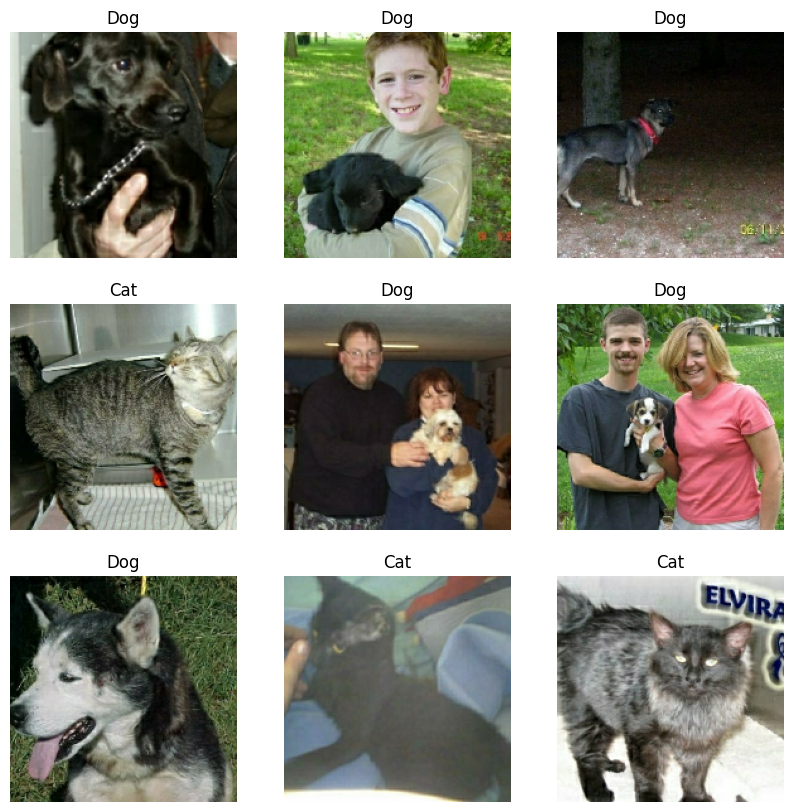

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [7]:
normalization_layer = layers.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9961261


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache(filename="./dataset/train_ds_cache").shuffle(200).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache(filename="./dataset/val_ds_cache").prefetch(buffer_size=AUTOTUNE)

In [11]:
# Deep Neural Network - Attempt 1

model = Sequential([
    layers.Flatten(input_shape=(180, 180, 3)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 97200)             0         
                                                                 
 dense (Dense)               (None, 256)               24883456  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 24,926,754
Trainable params: 24,926,754
No

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [12]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
257/257 [==============================] - 64s 221ms/step - loss: 598.0044 - accuracy: 0.5186 - val_loss: 57.7087 - val_accuracy: 0.5329
Epoch 2/5
257/257 [==============================] - 62s 226ms/step - loss: 84.8803 - accuracy: 0.5362 - val_loss: 45.6530 - val_accuracy: 0.5127
Epoch 3/5


2023-04-17 16:38:38.176563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 188 of 200
2023-04-17 16:38:39.035071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


257/257 [==============================] - 119s 421ms/step - loss: 43.2626 - accuracy: 0.5364 - val_loss: 17.2066 - val_accuracy: 0.5380
Epoch 4/5


2023-04-17 16:40:37.124976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 154 of 200
2023-04-17 16:40:43.030480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


257/257 [==============================] - 77s 239ms/step - loss: 10.1874 - accuracy: 0.5531 - val_loss: 10.3148 - val_accuracy: 0.5110
Epoch 5/5


2023-04-17 16:41:54.422186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 150 of 200
2023-04-17 16:41:57.072255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


257/257 [==============================] - 78s 254ms/step - loss: 4.8912 - accuracy: 0.5637 - val_loss: 1.3851 - val_accuracy: 0.5769


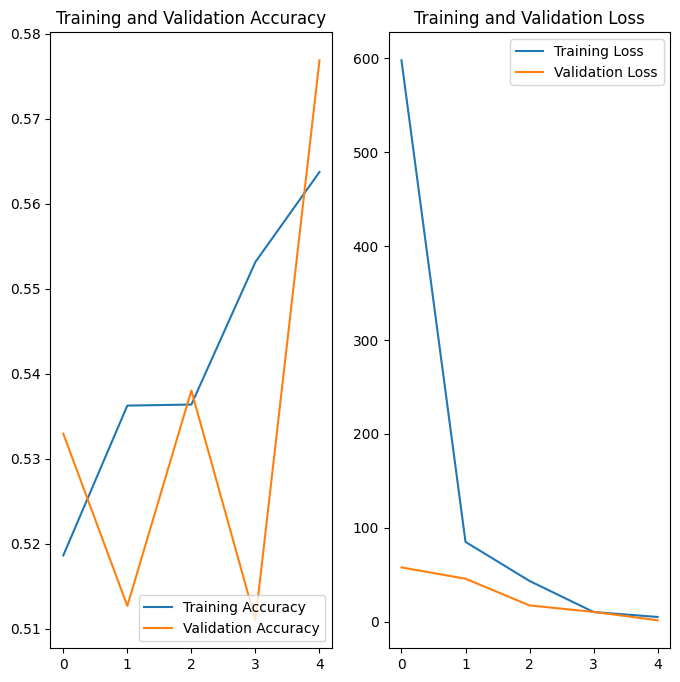

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Deep Neural Network - Attempt 2 with regularization

model = Sequential([
    layers.Flatten(input_shape=(180, 180, 3)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
257/257 [==============================] - 88s 313ms/step - loss: 455.1147 - accuracy: 0.5236 - val_loss: 157.4789 - val_accuracy: 0.5194
Epoch 2/5
257/257 [==============================] - 87s 303ms/step - loss: 84.8145 - accuracy: 0.5424 - val_loss: 106.4411 - val_accuracy: 0.5051
Epoch 3/5
257/257 [==============================] - 69s 240ms/step - loss: 29.3784 - accuracy: 0.5574 - val_loss: 16.7314 - val_accuracy: 0.5346
Epoch 4/5
257/257 [==============================] - 71s 256ms/step - loss: 12.7734 - accuracy: 0.5731 - val_loss: 12.5428 - val_accuracy: 0.5296
Epoch 5/5
257/257 [==============================] - 72s 244ms/step - loss: 9.5622 - accuracy: 0.5659 - val_loss: 6.8997 - val_accuracy: 0.5393


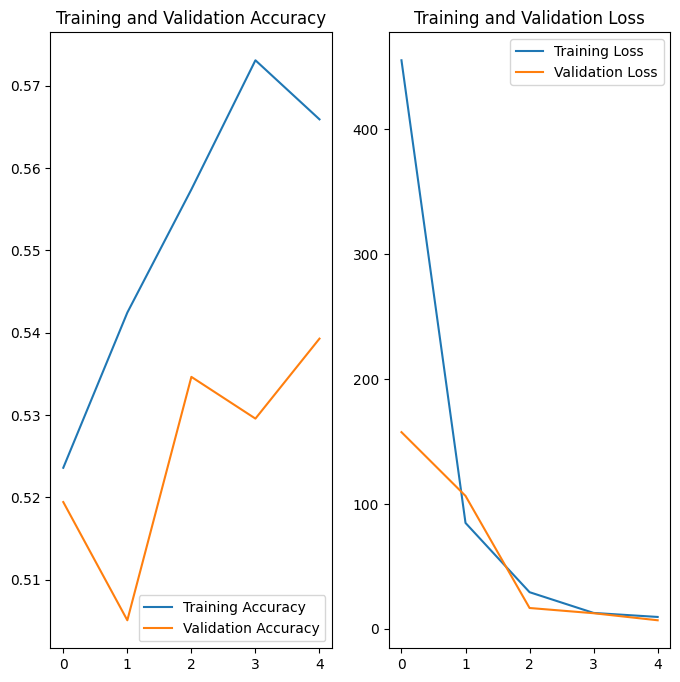

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# Convolutional Neural Network - Attempt 1

del model
del history

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


2023-04-17 17:34:19.564128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 78 of 200
2023-04-17 17:34:29.596940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 132 of 200
2023-04-17 17:34:39.602461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 189 of 200
2023-04-17 17:34:41.918513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


257/257 [==============================] - 85s 195ms/step - loss: 0.6529 - accuracy: 0.6047 - val_loss: 0.5718 - val_accuracy: 0.7019
Epoch 2/5
257/257 [==============================] - 42s 139ms/step - loss: 0.5418 - accuracy: 0.7209 - val_loss: 0.5114 - val_accuracy: 0.7572
Epoch 3/5
257/257 [==============================] - 37s 129ms/step - loss: 0.4629 - accuracy: 0.7808 - val_loss: 0.4742 - val_accuracy: 0.7741
Epoch 4/5
257/257 [==============================] - 38s 132ms/step - loss: 0.4243 - accuracy: 0.8054 - val_loss: 0.4880 - val_accuracy: 0.7787
Epoch 5/5
257/257 [==============================] - 40s 137ms/step - loss: 0.3622 - accuracy: 0.8350 - val_loss: 0.4584 - val_accuracy: 0.7880


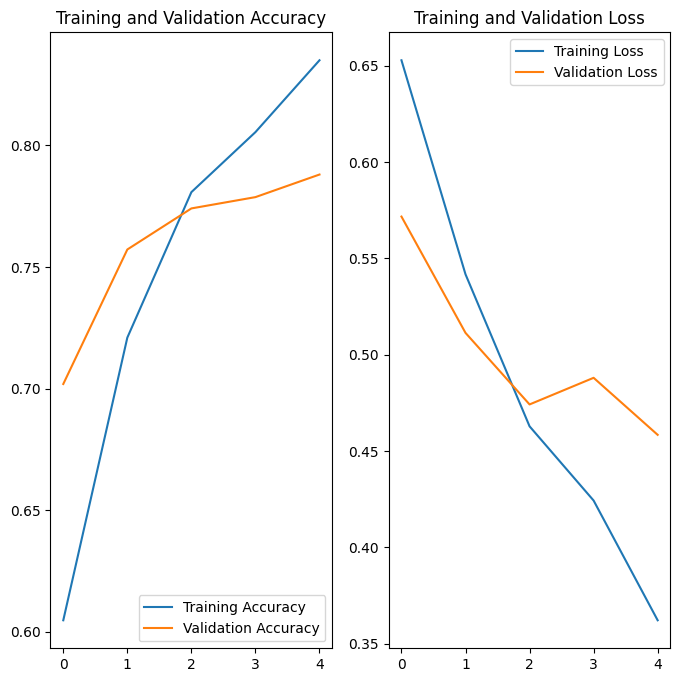

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Train more
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


2023-04-17 17:41:00.301013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 199 of 200
2023-04-17 17:41:00.390256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


257/257 [==============================] - 45s 134ms/step - loss: 0.3224 - accuracy: 0.8610 - val_loss: 0.5154 - val_accuracy: 0.7736
Epoch 2/5
257/257 [==============================] - 38s 133ms/step - loss: 0.2416 - accuracy: 0.9014 - val_loss: 0.5778 - val_accuracy: 0.7635
Epoch 3/5
257/257 [==============================] - 41s 146ms/step - loss: 0.1929 - accuracy: 0.9234 - val_loss: 0.5767 - val_accuracy: 0.7568
Epoch 4/5
257/257 [==============================] - 41s 136ms/step - loss: 0.1577 - accuracy: 0.9407 - val_loss: 0.6310 - val_accuracy: 0.7660
Epoch 5/5
257/257 [==============================] - 44s 147ms/step - loss: 0.1119 - accuracy: 0.9638 - val_loss: 0.6483 - val_accuracy: 0.7728


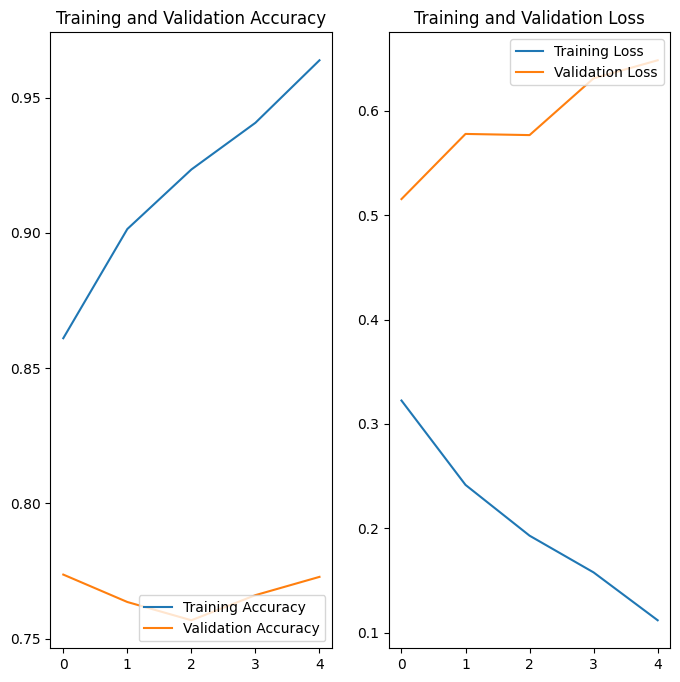

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# Convolutional Neural Network - Attempt 2 using dropout layer

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(10, activation="linear"),
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


2023-04-17 17:58:06.437248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 111 of 200
2023-04-17 17:58:16.499992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 168 of 200


  1/257 [..............................] - ETA: 1:40:14 - loss: 0.6967 - accuracy: 0.5312

2023-04-17 17:58:18.153434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


257/257 [==============================] - 51s 109ms/step - loss: 0.6303 - accuracy: 0.6313 - val_loss: 0.6036 - val_accuracy: 0.6976
Epoch 2/5
257/257 [==============================] - 34s 111ms/step - loss: 0.5420 - accuracy: 0.7285 - val_loss: 0.5317 - val_accuracy: 0.7432
Epoch 3/5
257/257 [==============================] - 33s 107ms/step - loss: 0.4984 - accuracy: 0.7600 - val_loss: 0.5042 - val_accuracy: 0.7551
Epoch 4/5
257/257 [==============================] - 32s 105ms/step - loss: 0.4797 - accuracy: 0.7723 - val_loss: 0.4850 - val_accuracy: 0.7720
Epoch 5/5
257/257 [==============================] - 32s 104ms/step - loss: 0.4481 - accuracy: 0.7888 - val_loss: 0.4596 - val_accuracy: 0.7918


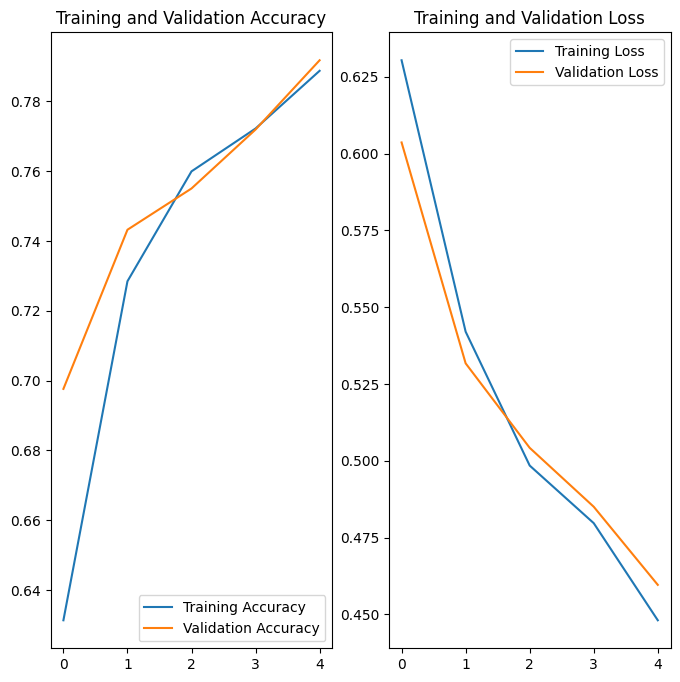

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
# train more

epochs=5
history= model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
257/257 [==============================] - 31s 102ms/step - loss: 0.4213 - accuracy: 0.8085 - val_loss: 0.4814 - val_accuracy: 0.7834
Epoch 2/5
257/257 [==============================] - 34s 110ms/step - loss: 0.4032 - accuracy: 0.8174 - val_loss: 0.5060 - val_accuracy: 0.7622
Epoch 3/5
257/257 [==============================] - 33s 109ms/step - loss: 0.3813 - accuracy: 0.8310 - val_loss: 0.4444 - val_accuracy: 0.8015
Epoch 4/5
257/257 [==============================] - 31s 104ms/step - loss: 0.3651 - accuracy: 0.8372 - val_loss: 0.4498 - val_accuracy: 0.7884
Epoch 5/5
257/257 [==============================] - 35s 117ms/step - loss: 0.3500 - accuracy: 0.8490 - val_loss: 0.4466 - val_accuracy: 0.7931


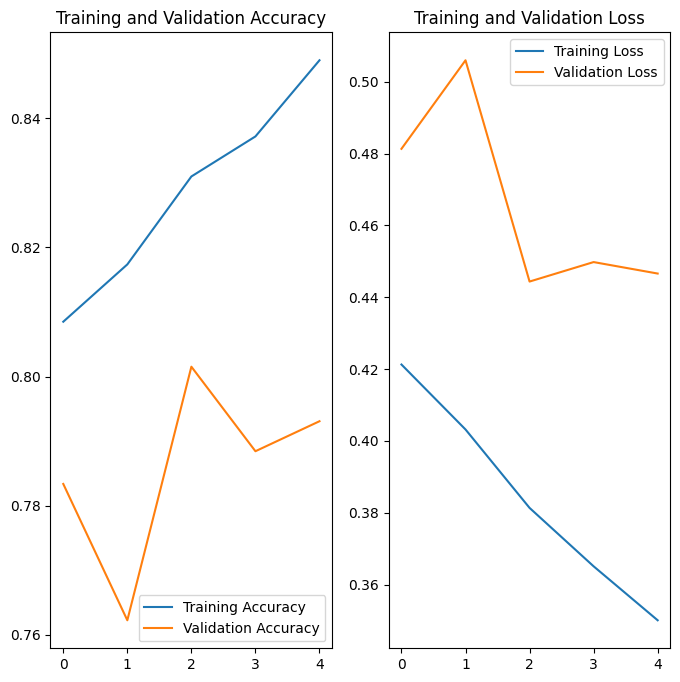

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# Create data augmentation layer
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.5),
  ]
)

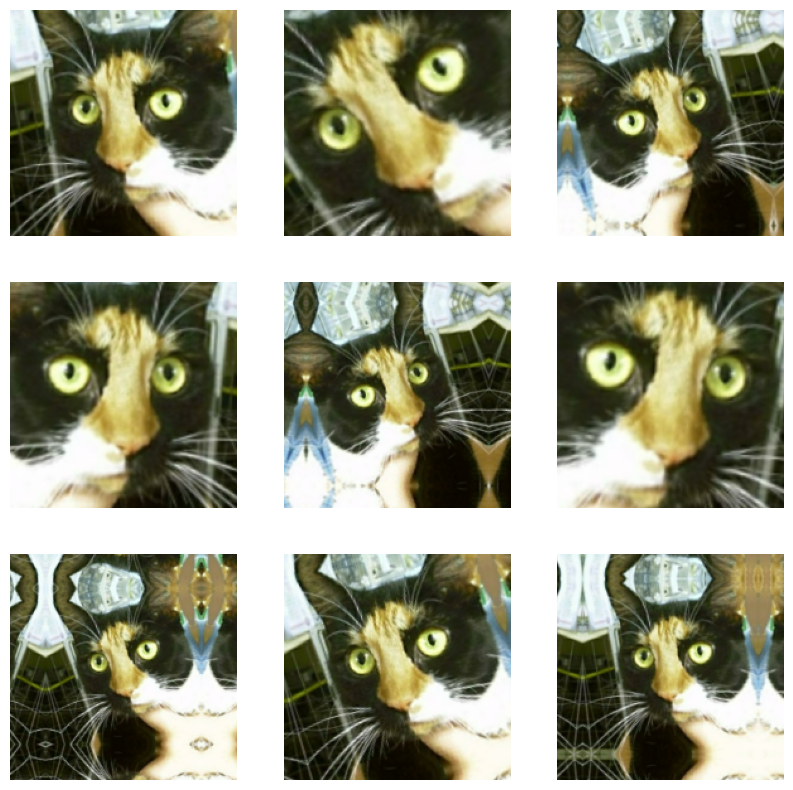

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [36]:
# Convolutional Neural Network - Attempt 3 using data augmentation

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(10, activation="linear"),
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs=5
history= model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
257/257 [==============================] - 37s 129ms/step - loss: 0.6921 - accuracy: 0.5379 - val_loss: 0.6680 - val_accuracy: 0.6242
Epoch 2/5
257/257 [==============================] - 39s 138ms/step - loss: 0.6751 - accuracy: 0.5621 - val_loss: 0.6520 - val_accuracy: 0.6081
Epoch 3/5
257/257 [==============================] - 41s 143ms/step - loss: 0.6547 - accuracy: 0.6169 - val_loss: 0.6005 - val_accuracy: 0.6917
Epoch 4/5
257/257 [==============================] - 44s 140ms/step - loss: 0.6198 - accuracy: 0.6592 - val_loss: 0.5693 - val_accuracy: 0.7204
Epoch 5/5
257/257 [==============================] - 42s 141ms/step - loss: 0.5973 - accuracy: 0.6824 - val_loss: 0.5559 - val_accuracy: 0.7196


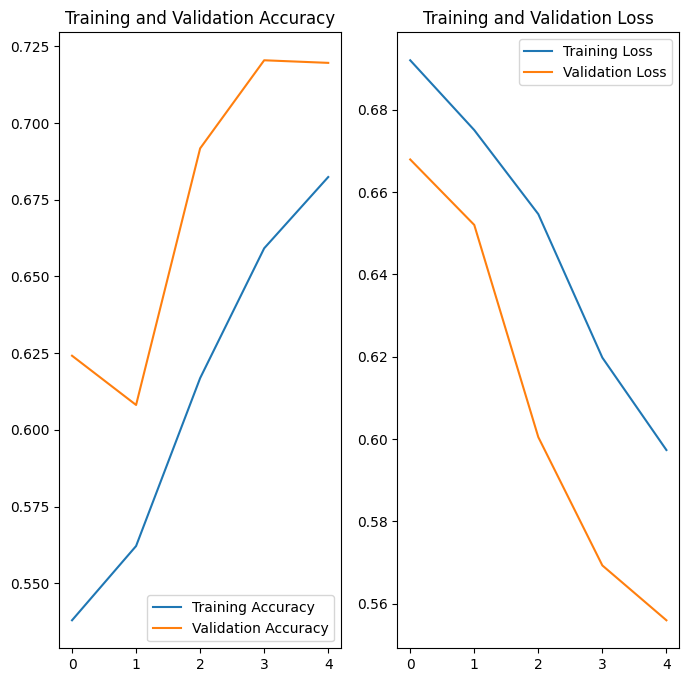

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
epochs=5
history= model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
257/257 [==============================] - 41s 135ms/step - loss: 0.5743 - accuracy: 0.7000 - val_loss: 0.5444 - val_accuracy: 0.7310
Epoch 2/5
257/257 [==============================] - 43s 141ms/step - loss: 0.5654 - accuracy: 0.7106 - val_loss: 0.5225 - val_accuracy: 0.7572
Epoch 3/5
257/257 [==============================] - 42s 141ms/step - loss: 0.5506 - accuracy: 0.7264 - val_loss: 0.5193 - val_accuracy: 0.7449
Epoch 4/5
257/257 [==============================] - 43s 141ms/step - loss: 0.5451 - accuracy: 0.7333 - val_loss: 0.5123 - val_accuracy: 0.7601
Epoch 5/5
257/257 [==============================] - 43s 142ms/step - loss: 0.5264 - accuracy: 0.7384 - val_loss: 0.4969 - val_accuracy: 0.7690


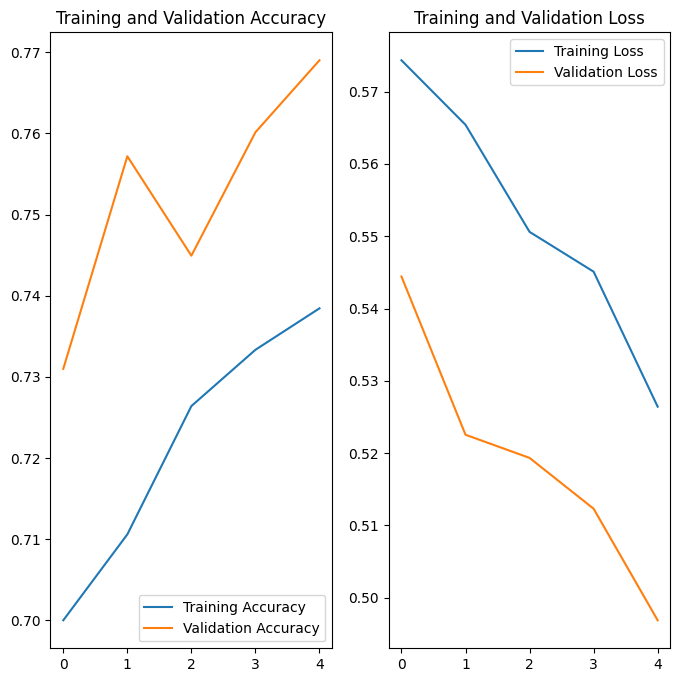

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
epochs=5
history= model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
257/257 [==============================] - 40s 131ms/step - loss: 0.5340 - accuracy: 0.7349 - val_loss: 0.4824 - val_accuracy: 0.7724
Epoch 2/5
257/257 [==============================] - 44s 144ms/step - loss: 0.5269 - accuracy: 0.7381 - val_loss: 0.4887 - val_accuracy: 0.7673
Epoch 3/5
257/257 [==============================] - 45s 145ms/step - loss: 0.5164 - accuracy: 0.7419 - val_loss: 0.4650 - val_accuracy: 0.7901
Epoch 4/5
257/257 [==============================] - 43s 141ms/step - loss: 0.5080 - accuracy: 0.7506 - val_loss: 0.4816 - val_accuracy: 0.7745
Epoch 5/5
257/257 [==============================] - 42s 137ms/step - loss: 0.5056 - accuracy: 0.7487 - val_loss: 0.4692 - val_accuracy: 0.7889


In [43]:
model.evaluate(test_ds)

36/36 [==============================] - 4s 74ms/step - loss: 0.4747 - accuracy: 0.7847


[0.47470346093177795, 0.7847222089767456]

In [52]:
# Test with a new image of a cat

cache_dir='dataset'

img_url = "https://t3.gstatic.com/licensed-image?q=tbn:ANd9GcRoT6NNDUONDQmlthWrqIi_frTjsjQT4UZtsJsuxqxLiaFGNl5s3_pBIVxS6-VsFUP_"
img_path = tf.keras.utils.get_file('cat_01', origin=img_url, cache_dir=cache_dir)

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Cat with a 83.39 percent confidence.


In [53]:
# Test with a new image of a dog

img_url = "https://thumbs.dreamstime.com/b/golden-retriever-dog-21668976.jpg"
img_path = tf.keras.utils.get_file('dog_01', origin=img_url, cache_dir=cache_dir)

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to Dog with a 76.51 percent confidence.


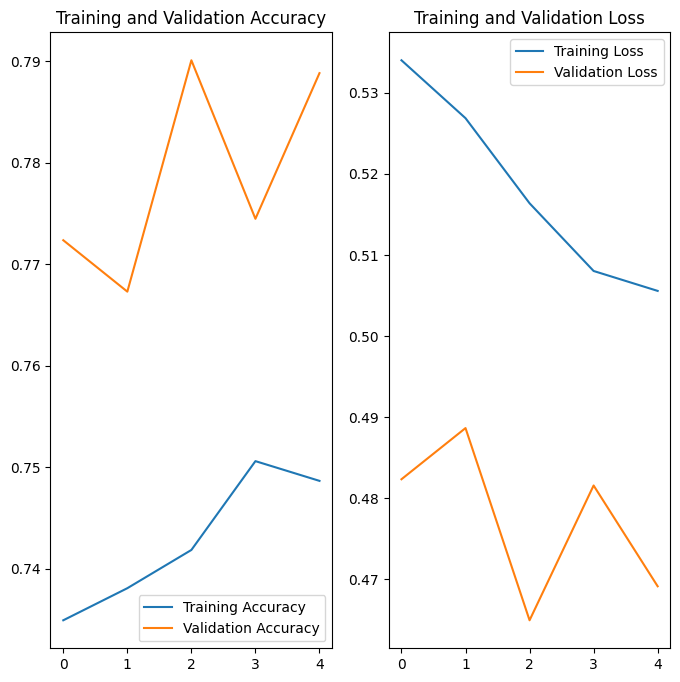

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()